### Classification of cifar-10 data using Convalutional Neural Networks

In [ ]:
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
import numpy as np
import pickle
import numpy
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy.misc import toimage
%matplotlib inline
import os


loading the cifar-10 dataset from keras

In [10]:
(x_train,y_train),(x_test,y_test)=cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

mean-std normalization

In [11]:
mean=np.mean(x_train,axis=(0,1,2,3))
std=np.std(x_train,axis=(0,1,2,3))
x_train=(x_train-mean)/(std+1e-7)
x_test=(x_test-mean)/(std+1e-7)

converting labels to categorical(one-hot encoding)

In [12]:
num_class=len(np.unique(y_train))
y_train=keras.utils.to_categorical(y_train,num_class)
y_test=keras.utils.to_categorical(y_test,num_class)

splitting the data into train and validation sets

In [13]:
(x_train,x_valid)=x_train[5000:],x_train[:5000]
(y_train,y_valid)=y_train[5000:],y_train[:5000]

In [14]:
print('train sample:',x_train.shape)
print('validation sample:',x_valid.shape)
print('test sample:',x_test.shape)
print('test sample:',y_train.shape)

train sample: (45000, 32, 32, 3)
validation sample: (5000, 32, 32, 3)
test sample: (10000, 32, 32, 3)
test sample: (45000, 10)


saving the the data so that there is no need to load and divide the data again and again



In [15]:
pickle_file='cifar-new.pickle'
if not os.path.isfile(pickle_file):
    print('SAving data to pickle file...')
    try:
        with open('cifar-new.pickle','wb') as pf:
            pickle.dump(
            {
                'train_dataset':x_train,
                'train_labels':y_train,
                'valid_dataset':x_valid,
                'valid_labels':y_valid,
                'test_dataset':x_test,
                'test_labels':y_test,
                
            },pf,pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save ',pickle_file,":",e)
        raise
print('Data cached in pickle file.')

SAving data to pickle file...
Data cached in pickle file.


In [15]:
pickle_file = 'cifar-new.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory

print('Data and modules loaded.')

Data and modules loaded.


In [6]:
print(train_features.shape)
print(valid_features.shape)

(45000, 32, 32, 3)
(5000, 32, 32, 3)


model architecture...

In [17]:
weight_decay=1e-4
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=3,padding='same',kernel_regularizer=regularizers.l2(weight_decay),input_shape=train_features.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32,kernel_size=3,padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_class, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2

Data augmentation to remove overfitting

In [18]:
datagen=ImageDataGenerator(
rotation_range=15,
width_shift_range=0.1,
height_shift_range=0.1,
horizontal_flip=True)
datagen.fit(train_features)

optimizers and compiling model

In [19]:
rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])

In [20]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate

model checkpoint saves the best weights 

In [22]:
batch_size = 64
epochs = 125

checkpointer = ModelCheckpoint(filepath='cifar-new.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
model.fit_generator(datagen.flow(train_features, train_labels, batch_size=batch_size),
                    steps_per_epoch=train_features.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[checkpointer,LearningRateScheduler(lr_schedule)],
                    validation_data=(valid_features, valid_labels),
                    validation_steps=valid_features.shape[0] // batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/125
 - 19s - loss: 1.9129 - acc: 0.4222 - val_loss: 1.6295 - val_acc: 0.5342

Epoch 00001: val_loss improved from inf to 1.62950, saving model to cifar-new.weights.best.hdf5
Epoch 2/125
 - 16s - loss: 1.2862 - acc: 0.5824 - val_loss: 1.1224 - val_acc: 0.6580

Epoch 00002: val_loss improved from 1.62950 to 1.12236, saving model to cifar-new.weights.best.hdf5
Epoch 3/125
 - 15s - loss: 1.0967 - acc: 0.6463 - val_loss: 0.9744 - val_acc: 0.7090

Epoch 00003: val_loss improved from 1.12236 to 0.97440, saving model to cifar-new.weights.best.hdf5
Epoch 4/125
 - 16s - loss: 0.9976 - acc: 0.6835 - val_loss: 0.9262 - val_acc: 0.7180

Epoch 00004: val_loss improved from 0.97440 to 0.92624, saving model to cifar-new.weights.best.hdf5
Epoch 5/125
 - 15s - loss: 0.9286 - acc: 0.7089 - val_loss: 0.8832 - val_acc: 0.7508

Epoch 00005: val_loss improved from 0.92624 to 0.88325, saving model to cifar-new.weights.best.hdf5
Epoch 6/125
 - 15s - loss:


Epoch 00052: val_loss did not improve from 0.53348
Epoch 53/125
 - 18s - loss: 0.5931 - acc: 0.8469 - val_loss: 0.5189 - val_acc: 0.8792

Epoch 00053: val_loss improved from 0.53348 to 0.51889, saving model to cifar-new.weights.best.hdf5
Epoch 54/125
 - 17s - loss: 0.5955 - acc: 0.8471 - val_loss: 0.6002 - val_acc: 0.8548

Epoch 00054: val_loss did not improve from 0.51889
Epoch 55/125
 - 16s - loss: 0.5968 - acc: 0.8458 - val_loss: 0.5690 - val_acc: 0.8598

Epoch 00055: val_loss did not improve from 0.51889
Epoch 56/125
 - 16s - loss: 0.5930 - acc: 0.8470 - val_loss: 0.5292 - val_acc: 0.8754

Epoch 00056: val_loss did not improve from 0.51889
Epoch 57/125
 - 16s - loss: 0.5925 - acc: 0.8482 - val_loss: 0.5600 - val_acc: 0.8600

Epoch 00057: val_loss did not improve from 0.51889
Epoch 58/125
 - 16s - loss: 0.5915 - acc: 0.8496 - val_loss: 0.5207 - val_acc: 0.8756

Epoch 00058: val_loss did not improve from 0.51889
Epoch 59/125
 - 17s - loss: 0.5895 - acc: 0.8480 - val_loss: 0.6134 - v

 - 16s - loss: 0.4489 - acc: 0.8839 - val_loss: 0.4291 - val_acc: 0.9006

Epoch 00109: val_loss did not improve from 0.41934
Epoch 110/125
 - 16s - loss: 0.4487 - acc: 0.8847 - val_loss: 0.4448 - val_acc: 0.8874

Epoch 00110: val_loss did not improve from 0.41934
Epoch 111/125
 - 16s - loss: 0.4517 - acc: 0.8828 - val_loss: 0.4972 - val_acc: 0.8816

Epoch 00111: val_loss did not improve from 0.41934
Epoch 112/125
 - 16s - loss: 0.4475 - acc: 0.8848 - val_loss: 0.4538 - val_acc: 0.8898

Epoch 00112: val_loss did not improve from 0.41934
Epoch 113/125
 - 19s - loss: 0.4490 - acc: 0.8843 - val_loss: 0.4630 - val_acc: 0.8826

Epoch 00113: val_loss did not improve from 0.41934
Epoch 114/125
 - 17s - loss: 0.4446 - acc: 0.8855 - val_loss: 0.4553 - val_acc: 0.8872

Epoch 00114: val_loss did not improve from 0.41934
Epoch 115/125
 - 16s - loss: 0.4470 - acc: 0.8851 - val_loss: 0.4509 - val_acc: 0.8884

Epoch 00115: val_loss did not improve from 0.41934
Epoch 116/125
 - 18s - loss: 0.4429 - acc

loading the saved best weigths

In [20]:
model.load_weights('cifar-new.weights.best.hdf5')

testing the model

In [19]:
score=model.evaluate(test_features,test_labels,verbose=0)
print('test accuracy:',score[1])

test accuracy: 0.893


In [18]:
rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])

In [8]:
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
 

NameError: name 'model' is not defined

In [16]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('cifar-new.weights.best.hdf5')

In [10]:
y_hat = model.predict(test_features)

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

c:\program files\python35\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


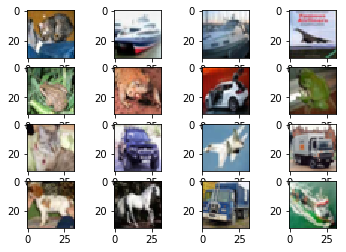

['cat', 'ship', 'ship', 'ship', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship']


In [12]:

def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
 
show_imgs(test_features[:16])
indices = np.argmax(model.predict(test_features[:16]),1)
print ([cifar10_labels[x] for x in indices])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AttributeError: module 'numpy' has no attribute 'argm'

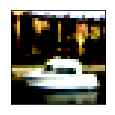

In [11]:
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(test_features.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_features[idx]))
    pred_idx = np.argm.ax(y_hat[idx])
    true_idx = np.argmax(test_labels[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))


In [22]:
pickle_file = 'cifar-new.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory

print('Data and modules loaded.')

Data and modules loaded.


In [23]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('cifar-new.weights.best.hdf5')
print('model and weights loded')

model and weights loded


In [24]:
rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
print('model compiled')

model compiled


In [25]:
score=model.evaluate(test_features,test_labels,verbose=0)
print('test accuracy:',score[1])

test accuracy: 0.893


In [26]:
y_hat = model.predict(test_features)

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

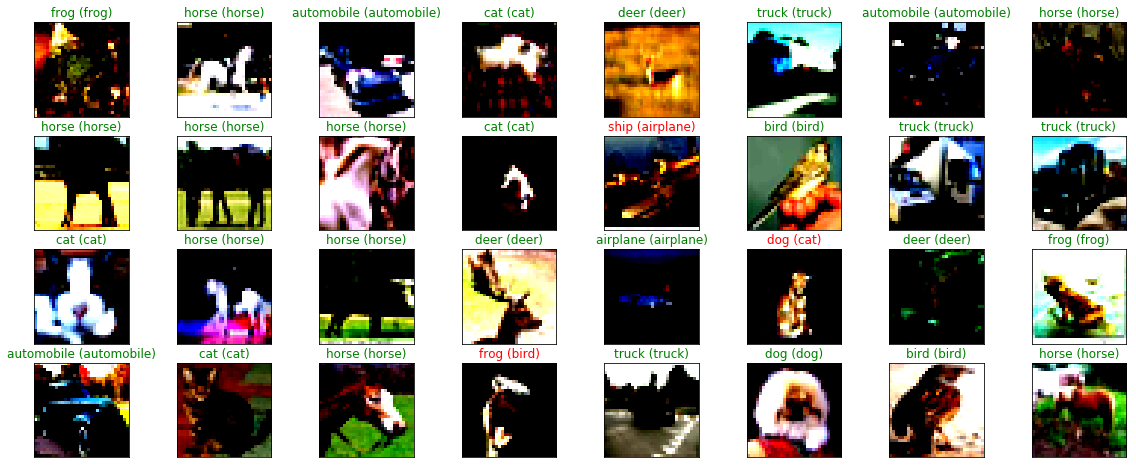

In [30]:
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(test_features.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(test_features[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(test_labels[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

c:\program files\python35\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


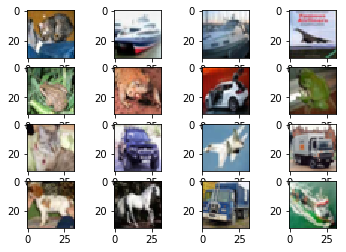

['cat', 'ship', 'ship', 'ship', 'frog', 'frog', 'automobile', 'frog', 'cat', 'automobile', 'airplane', 'truck', 'dog', 'horse', 'truck', 'ship']


In [28]:
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
 
show_imgs(test_features[:16])
indices = np.argmax(model.predict(test_features[:16]),1)
print ([cifar10_labels[x] for x in indices])